In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔧 Building BoW vocabulary...
✅ Vocabulary created.
🎓 Training SVM...
✅ SVM trained.

🔎 Sample predictions:

🔍 Random test samples:

🧠 Prediction: Car Detected | True: Car


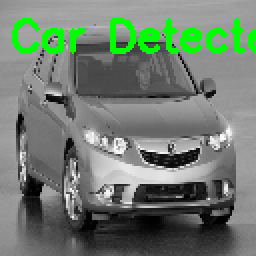

🧠 Prediction: Car Detected | True: Car


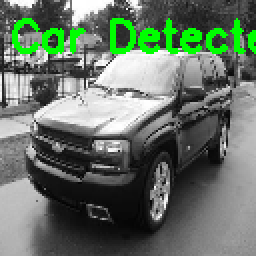

🧠 Prediction: Not a Car | True: Car


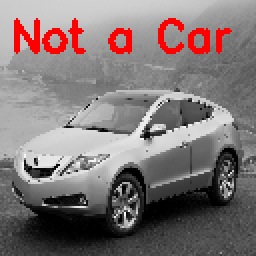

⚠️ Not enough keypoints.
🧠 Prediction: Not a Car | True: Not Car


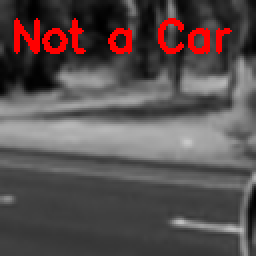

🧠 Prediction: Not a Car | True: Not Car


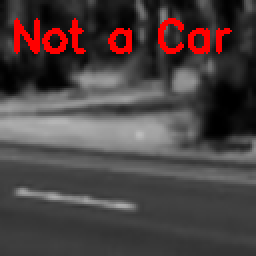

📊 Final accuracy on test set: 81.31%


In [11]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Parameters
BOW_CLUSTER_COUNT = 200
MIN_SIFT_KEYPOINTS = 10
IMAGE_SIZE = (128, 128)

# Initialize SIFT and FLANN
sift = cv2.SIFT_create()
flann_params = dict(algorithm=1, trees=5)
flann = cv2.FlannBasedMatcher(flann_params, {})
bow_trainer = cv2.BOWKMeansTrainer(BOW_CLUSTER_COUNT)
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

# Function to load and preprocess images from a folder
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(gray)
            labels.append(label)
    return images, labels

# Training data paths
train_car_path = '/content/drive/MyDrive/car_data/Train/car'
train_not_car_path = '/content/drive/MyDrive/car_data/Train/non-car'

# Test data paths
test_car_path = '/content/drive/MyDrive/car_data/Test/car'
test_not_car_path = '/content/drive/MyDrive/car_data/Test/non-car'

# Load training data
car_imgs, car_labels = load_images_from_folder(train_car_path, 1)
not_car_imgs, not_car_labels = load_images_from_folder(train_not_car_path, 0)

all_train_imgs = car_imgs + not_car_imgs
all_train_labels = car_labels + not_car_labels

# Step 1: Build the BoW vocabulary using good quality descriptors only
import random

# Limit vocabulary building to 1000 random images
sampled_imgs = random.sample(all_train_imgs, 1000)

for img in sampled_imgs:
    kp = sift.detect(img, None)
    if len(kp) >= MIN_SIFT_KEYPOINTS:
        _, des = sift.compute(img, kp)
        if des is not None:
            bow_trainer.add(des)

print("🔧 Building BoW vocabulary...")
vocab = bow_trainer.cluster()
bow_extractor.setVocabulary(vocab)
print("✅ Vocabulary created.")

# Step 2: Extract BoW features
traindata = []
trainlabels = []

for img, label in zip(all_train_imgs, all_train_labels):
    kp = sift.detect(img, None)
    if len(kp) >= MIN_SIFT_KEYPOINTS:
        feat = bow_extractor.compute(img, kp)
        if feat is not None:
            traindata.append(feat)
            trainlabels.append(label)

traindata = np.array(traindata).squeeze()
trainlabels = np.array(trainlabels)

# Step 3: Train the SVM classifier
print("🎓 Training SVM...")
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(1)
svm.train(traindata, cv2.ml.ROW_SAMPLE, trainlabels)
print("✅ SVM trained.")

# Load test data
test_car_imgs, test_car_labels = load_images_from_folder(test_car_path, 1)
test_not_car_imgs, test_not_car_labels = load_images_from_folder(test_not_car_path, 0)

test_imgs = test_car_imgs + test_not_car_imgs
test_labels = test_car_labels + test_not_car_labels

# Step 4: Evaluate the model on test data
correct = 0
total = 0

for img, label in zip(test_imgs, test_labels):
    kp = sift.detect(img, None)
    if len(kp) >= MIN_SIFT_KEYPOINTS:
        feat = bow_extractor.compute(img, kp)
        if feat is not None:
            _, result = svm.predict(feat)
            pred = int(result[0][0])
            correct += (pred == label)
            total += 1
# Function to predict and display an image with label
def predict_and_show(img, true_label=None):
    kp = sift.detect(img, None)
    if len(kp) < MIN_SIFT_KEYPOINTS:
        print("⚠️ Not enough keypoints.")
        return
    feat = bow_extractor.compute(img, kp)
    if feat is None:
        print("⚠️ No feature extracted.")
        return
    _, result = svm.predict(feat)
    pred = int(result[0][0])

    label_text = "Car Detected" if pred == 1 else "Not a Car"
    color = (0, 255, 0) if pred == 1 else (0, 0, 255)

    # Convert to BGR for drawing
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.putText(img_color, label_text, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    img_resized = cv2.resize(img_color, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Show true label if provided
    if true_label is not None:
        truth = "True: Car" if true_label == 1 else "True: Not Car"
        print(f"🧠 Prediction: {label_text} | {truth}")

    cv2_imshow(img_resized)

    # Show predictions on some test samples
print("\n🔎 Sample predictions:\n")
import random
random.seed(42)

print("🔍 Random test samples:\n")

for _ in range(3):
    i = random.randint(0, len(test_car_imgs)-1)
    predict_and_show(test_car_imgs[i], 1)

for _ in range(3):
    i = random.randint(0, len(test_not_car_imgs)-1)
    predict_and_show(test_not_car_imgs[i], 0)


accuracy = correct / total if total else 0
print(f"📊 Final accuracy on test set: {accuracy * 100:.2f}%")





In [7]:


print("Number of car train images:", len(car_imgs))
print("Number of non-car train images:", len(not_car_imgs))
print("Number of car test images:", len(test_car_imgs))
print("Number of non-car test images:", len(test_not_car_imgs))


Number of car train images: 3099
Number of non-car train images: 3852
Number of car test images: 2796
Number of non-car test images: 1558
